[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/neverorfrog/whistlenet/blob/main/whistlenet/scripts/main_whistle_colab.ipynb)

In [2]:
import sys

COLAB_RUNTIME = 'google.colab' in sys.modules
if COLAB_RUNTIME:
    !git init
    !git remote add origin https://github.com/neverorfrog/whistlenet.git
    !git pull origin main
    !pip install -q -r requirements.txt
else:
    !pip install -q -r requirements.txt
    !pre-commit install

Reinitialized existing Git repository in /content/.git/
error: remote origin already exists.
From https://github.com/neverorfrog/whistlenet
 * branch            main       -> FETCH_HEAD
Already up to date.


In [3]:
from config import *
import os
import warnings
warnings.filterwarnings("ignore")
import torch
import numpy as np
from whistlenet.core.utils import project_root

config_path = os.path.join(project_root(), "config","whistle_config.yaml")
config: Config = load_config(config_path)
torch_config: TorchConfig = config.torch
dataset_config: DatasetConfig = config.dataset
trainer_config: TrainerConfig = config.trainer
baseline_config: BaselineConfig = config.baseline
whistlenet_config: WhistlenetConfig = config.whistlenet
torch.manual_seed(torch_config.seed)
np.random.seed(torch_config.seed)

Retrieving folder contents


Processing file 16AYpKThc9EEL135p9XvVeTKoUvsvrClw test_data.dat
Processing file 1CrWF7ieQunHWCWMzX_jGp1f3MV3oNnFV train_data.dat
Processing file 1nJEXf5wtxUVFzQQo9zrKSYtgdKt7zGmG val_data.dat


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=16AYpKThc9EEL135p9XvVeTKoUvsvrClw
From (redirected): https://drive.google.com/uc?id=16AYpKThc9EEL135p9XvVeTKoUvsvrClw&confirm=t&uuid=a352d428-4f1a-4adb-8e94-1afb2e502de7
To: /content/data/whistle/saved/naodevils/test_data.dat
100%|██████████| 901M/901M [00:04<00:00, 183MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1CrWF7ieQunHWCWMzX_jGp1f3MV3oNnFV
From (redirected): https://drive.google.com/uc?id=1CrWF7ieQunHWCWMzX_jGp1f3MV3oNnFV&confirm=t&uuid=fc3555cf-1c7f-4246-9ada-e5c6dc4f7ccc
To: /content/data/whistle/saved/naodevils/train_data.dat
100%|██████████| 3.00G/3.00G [00:17<00:00, 172MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1nJEXf5wtxUVFzQQo9zrKSYtgdKt7zGmG
From (redirected): https://drive.google.com/uc?id=1nJEXf5wtxUVFzQQo9zrKSYtgdKt7zGmG&confirm=t&uuid=a2762d98-0882-4808

DATA LOADED!

N Examples: 490053
N Classes: 2
Classes: [0. 1.]
 - Class 0: 273375 (55.784782462305095)
 - Class 1: 216678 (44.2152175376949)


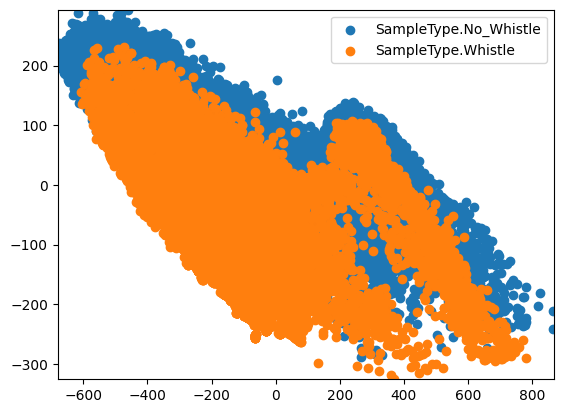

In [4]:
from whistlenet.data import WhistleDataset
from whistlenet.core.utils import plot, NUM_FREQS
from whistlenet.core.utils.audio import SampleType
import gdown

download_path = os.path.join(dataset_config.download_folder, dataset_config.name)
gdown.download_folder(
   dataset_config.drive_url, output=download_path
)

dataset = WhistleDataset(dataset_config)
dataset.summarize()
reshaped = dataset.train_data.reshape((dataset.train_data.data.shape[0], NUM_FREQS))
plot(reshaped, dataset.train_data.labels, SampleType)

In [5]:
from whistlenet.models import WhistleNet, Baseline
from whistlenet.core import LightningTrainer

model = WhistleNet(in_channels=1, out_channels=1, config=whistlenet_config)
trainer = LightningTrainer(trainer_config)
trainer.fit(model,dataset)

AttributeError: partially initialized module 'wandb' has no attribute 'data_types' (most likely due to a circular import)

In [ ]:
baseline = Baseline(config=baseline_config)
trainer = LightningTrainer(trainer_config)
trainer.fit(baseline,dataset)